In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scdna_replication_tools.plot_utils import plot_cell_cn_profile2, plot_clustered_cell_cn_matrix, get_htert_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load and preprocess data showing the fraction of replicated bins per S-phase cell

In [3]:
datasets = ['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1054', 'SA1055', 'SA1056']
htert_rt = []

for d in datasets:
    temp_df = pd.read_csv('../../analysis/sig_lines/{}/scRT_pseudobulks.tsv'.format(d), sep='\t', usecols=['chr', 'start', 'pseudobulk_model_rep_state'])
    # add the dataset name as a column
    temp_df['dataset'] = d
    # append to the list
    htert_rt.append(temp_df)

htert_rt = pd.concat(htert_rt, ignore_index=True)
htert_rt.head()

,chr,start,pseudobulk_model_rep_state,dataset
0,1,1000001,0.947808,SA039
1,1,1500001,0.957550,SA039
2,1,2000001,0.959638,SA039
3,1,3000001,0.893528,SA039
4,1,4000001,0.788448,SA039


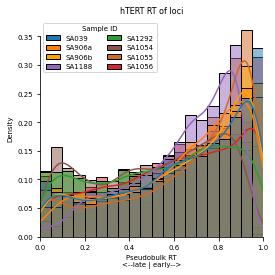

In [4]:
def plot_loci_rt_distribution(df, ax):
    htert_cmap = get_htert_cmap()
    df['sample'] = df['dataset']

    # plot both a histogram and kdeplot
    sns.histplot(
        data=df, x='pseudobulk_model_rep_state', hue='sample', ax=ax, palette=htert_cmap,
        stat='density', bins=20, cbar_kws={'edgecolor': 'k', 'linewidth': 0}, kde=True,
        legend=False
    )

    ax.set_xlabel('Pseudobulk RT\n<--late | early-->')
    ax.set_xlim(0, 1)
    ax.set_title('hTERT RT of loci')
    
    # generate handles and labels for the legend from the histplot
    # note that the ax.get_legend_handles_labels() returns empty labels for the histplot
    # so we need to manually generate the labels
    handles = []
    labels = []
    for i, d in enumerate(datasets):
        # plot the rectangle with the same saturation and border color as the histplot
        handle = plt.Rectangle((0,0),1,1, fc=htert_cmap[d], ec='k')
        handles.append(handle)
        labels.append(d)

    # plot the legend with two columns using the handles and labels from the histplot
    ax.legend(
        handles=handles, 
        labels=labels, 
        title='Sample ID',
        loc='upper left', ncol=2
    )
    
    sns.despine(ax=ax, offset=0, trim=despine_trim)


# plot the distribution of fraction of replicated bins for hTERT S-phase cells in the top right subplot
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plot_loci_rt_distribution(htert_rt, ax)
plt.show()

### Load and preprocess the data which allows me to compare sample CNAs vs ancestral RT

In [5]:
def load_clone_rt_data(datasets, rt_paths):
    # load dataset pseudobulk rt profiles
    rt = pd.DataFrame()
    for d in datasets:
        temp_rt = pd.read_csv(rt_paths.format(d), sep='\t')
        # set chr and start as the index columns
        temp_rt = temp_rt.set_index(['chr', 'start'])
        # subset to only the columns containing 'clone' and 'model_rep_state' substrings
        temp_rt = temp_rt[[c for c in temp_rt.columns if 'clone' in c and 'model_rep_state' in c]]
        # add the dataset d as the prefix for all the column names
        temp_rt = temp_rt.add_prefix('{}_'.format(d))
        # remove the 'pseudobulk_' substring from the column names
        temp_rt = temp_rt.rename(columns={c: c.replace('pseudobulk_', '') for c in temp_rt.columns})
        # replace the 'model_rep_state' substring with 'pseudobulk_rt' in the column names
        temp_rt = temp_rt.rename(columns={c: c.replace('model_rep_state', 'pseudobulk_rt') for c in temp_rt.columns})
        
        # reset the index
        temp_rt = temp_rt.reset_index()
        if rt.empty:
            rt = temp_rt
        else:
            rt = pd.merge(rt, temp_rt)

    # set chr column to category
    rt.chr = rt.chr.astype('str').astype('category')

    rt['end'] = rt['start'] + 500000 - 1
            
    return rt
    

def load_clone_cn_data(datasets, cn_paths):
    # load dataset pseudobulk cn profiles
    cn = pd.DataFrame()

    for d in datasets:
        temp_cn = pd.read_csv(cn_paths.format(d), sep='\t')

        # set chr and start as the index columns
        temp_cn = temp_cn.set_index(['chr', 'start'])
        # subset to only the columns containing 'clone' and 'model_rep_state' substrings
        temp_cn = temp_cn[[c for c in temp_cn.columns if 'clone' in c]]
        # add the dataset d as the prefix for all the column names
        temp_cn = temp_cn.add_prefix('{}_'.format(d))
        # replace the 'clone_' substring with 'clone' in the column names
        temp_cn = temp_cn.rename(columns={c: c.replace('clone_', 'clone') for c in temp_cn.columns})
        # add the '_pseudobulk_cn' suffix to the column names
        temp_cn = temp_cn.rename(columns={c: '{}_pseudobulk_cn'.format(c) for c in temp_cn.columns})

        # reset the index
        temp_cn = temp_cn.reset_index()
        
        if cn.empty:
            cn = temp_cn
        else:
            cn = pd.merge(cn, temp_cn)


    # set chr column to category
    cn.chr = cn.chr.astype('str').astype('category')

    cn['end'] = cn['start'] + 500000 - 1

    return cn

In [6]:
def make_bk_clones(cn, clones):
    # create a table of copy number breakpoints for sample pseudobulk data
    # copy over the chromosome, start, and end columns
    cn_breakpoints = cn[['chr', 'start', 'end']].copy()
    for c in clones:
        # create a column for the copy number breakpoints
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)] = cn['{}_pseudobulk_cn'.format(c)].diff().fillna(0).astype('int')
        # convert all nonzero values to 1
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)] = cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)].apply(lambda x: 1 if x!=0 else 0)

    return cn_breakpoints


def compute_relative_rt_and_cn_clones(cn, rt, clones):
    for c in clones:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_cloneA_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(c)
        temp_cn_col = '{}_pseudobulk_cn'.format(c)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(c)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        
        rt[relative_rt_col] = rt[temp_rt_col] - rt[ref_rt_col]
        cn[relative_cn_col] = (cn[temp_cn_col] / cn[temp_cn_col].mode().values[0]) - (cn[ref_cn_col] / cn[ref_cn_col].mode().values[0])
    
    return cn, rt


def merge_cn_and_rt_info_clones(cn, rt, bk, clones):
    # merge the cn and rt tables into one long-form dataframe
    df = []

    for c in clones:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_cloneA_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(c)
        temp_cn_col = '{}_pseudobulk_cn'.format(c)
        temp_bk_col = '{}_pseudobulk_cn_breakpoints'.format(c)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(c)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        
        temp_df = pd.DataFrame({
            'chr': cn['chr'], 'start': cn['start'], 'end': cn['end'], 'clone': [c]*cn.shape[0],
            'WT_pseudobulk_rt': rt[ref_rt_col], 'WT_pseudobulk_cn': cn[ref_cn_col],
            'pseudobulk_rt': rt[temp_rt_col], 'pseudobulk_cn': cn[temp_cn_col], 'pseudobulk_bk': bk[temp_bk_col],
            'relative_rt': rt[relative_rt_col], 'relative_cn': cn[relative_cn_col]
        })
        
        df.append(temp_df)

    df = pd.concat(df, ignore_index=True)

    return df

In [7]:
datasets = [
    'SA039', 'SA906a', 'SA906b', 'SA1292', 'SA1056', 'SA1188', 'SA1054', 'SA1055'
]
rt_paths = '../../analysis/sig_lines/{}/scRT_pseudobulks.tsv'
cn_paths = '../../analysis/sig_lines/{}/cn_pseudobulks.tsv'

# load the rt and cn data
rt_clone = load_clone_rt_data(datasets, rt_paths)
cn_clone = load_clone_cn_data(datasets, cn_paths)

# remove the site of p53 deletion on chr17
chr17_start_thresh = 21000001
cn_clone = cn_clone.loc[~((cn_clone['chr'] == '17') & (cn_clone['start'] <= chr17_start_thresh))]
rt_clone = rt_clone.loc[~((rt_clone['chr'] == '17') & (rt_clone['start'] <= chr17_start_thresh))]
rt_clone.head()

,chr,start,SA039_cloneA_pseudobulk_rt,SA039_cloneB_pseudobulk_rt,SA039_cloneC_pseudobulk_rt,SA039_cloneD_pseudobulk_rt,SA906a_cloneA_pseudobulk_rt,SA906a_cloneB_pseudobulk_rt,SA906a_cloneC_pseudobulk_rt,SA906a_cloneD_pseudobulk_rt,...,SA1055_cloneB_pseudobulk_rt,SA1055_cloneC_pseudobulk_rt,SA1055_cloneD_pseudobulk_rt,SA1055_cloneE_pseudobulk_rt,SA1055_cloneF_pseudobulk_rt,SA1055_cloneG_pseudobulk_rt,SA1055_cloneH_pseudobulk_rt,SA1055_cloneI_pseudobulk_rt,SA1055_cloneJ_pseudobulk_rt,end
0,1,1000001,0.944694,0.954,0.935065,1.000000,0.829268,0.785714,0.533333,0.909375,...,0.5,1.0,1.000000,0.8,0.8,1.0,1.0,0.914286,1.0,1500000
1,1,1500001,0.949178,0.968,0.952381,1.000000,0.959350,0.878571,0.866667,0.943750,...,0.5,1.0,0.833333,0.6,0.6,1.0,1.0,0.885714,1.0,2000000
2,1,2000001,0.955157,0.968,0.952381,0.972973,0.878049,0.828571,0.555556,0.900000,...,0.5,1.0,1.000000,0.8,0.8,1.0,1.0,0.914286,1.0,2500000
3,1,3000001,0.877429,0.910,0.891775,0.972973,0.878049,0.707143,0.577778,0.843750,...,0.5,1.0,1.000000,0.8,0.6,1.0,1.0,0.771429,1.0,3500000
4,1,4000001,0.765321,0.830,0.753247,0.864865,0.878049,0.757143,0.755556,0.743750,...,0.5,1.0,1.000000,0.6,0.6,1.0,1.0,0.771429,0.8,4500000


In [8]:
cn_clone.head()

,chr,start,SA039_cloneA_pseudobulk_cn,SA039_cloneB_pseudobulk_cn,SA039_cloneC_pseudobulk_cn,SA039_cloneD_pseudobulk_cn,SA906a_cloneA_pseudobulk_cn,SA906a_cloneB_pseudobulk_cn,SA906a_cloneC_pseudobulk_cn,SA906a_cloneD_pseudobulk_cn,...,SA1055_cloneB_pseudobulk_cn,SA1055_cloneC_pseudobulk_cn,SA1055_cloneD_pseudobulk_cn,SA1055_cloneE_pseudobulk_cn,SA1055_cloneF_pseudobulk_cn,SA1055_cloneG_pseudobulk_cn,SA1055_cloneH_pseudobulk_cn,SA1055_cloneI_pseudobulk_cn,SA1055_cloneJ_pseudobulk_cn,end
0,1,1000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,1500000
1,1,1500001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,2000000
2,1,2000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,2500000
3,1,3000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,3500000
4,1,4000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4500000


In [9]:
htert_clones = [c.replace('_pseudobulk_cn', '') for c in cn_clone.set_index(['chr', 'start', 'end']).columns.tolist()]

# make a table of copy number breakpoints
bk_clone = make_bk_clones(cn_clone, htert_clones)

# compute the relative RT and CN values for each dataset
cn_clone, rt_clone = compute_relative_rt_and_cn_clones(cn_clone, rt_clone, htert_clones)

# merge the cn and rt tables into one long-form dataframe
df_clone = merge_cn_and_rt_info_clones(cn_clone, rt_clone, bk_clone, htert_clones)

# create column to denote whether a particular bin has a gain, loss, or no cna
df_clone['cna_type'] = 'unaltered'
for i, row in df_clone.iterrows():
    if row['relative_cn'] > 0:
        df_clone.loc[i, 'cna_type'] = 'gain'
    elif row['relative_cn'] < 0:
        df_clone.loc[i, 'cna_type'] = 'loss'

# rename bk column
df_clone['breakpoint'] = df_clone['pseudobulk_bk'].replace({0: 'No', 1: 'Yes'})
df_clone.head()

,chr,start,end,clone,WT_pseudobulk_rt,WT_pseudobulk_cn,pseudobulk_rt,pseudobulk_cn,pseudobulk_bk,relative_rt,relative_cn,cna_type,breakpoint
0,1,1000001,1500000,SA039_cloneA,0.944694,2.0,0.944694,2.0,0,0.0,0.0,unaltered,No
1,1,1500001,2000000,SA039_cloneA,0.949178,2.0,0.949178,2.0,0,0.0,0.0,unaltered,No
2,1,2000001,2500000,SA039_cloneA,0.955157,2.0,0.955157,2.0,0,0.0,0.0,unaltered,No
3,1,3000001,3500000,SA039_cloneA,0.877429,2.0,0.877429,2.0,0,0.0,0.0,unaltered,No
4,1,4000001,4500000,SA039_cloneA,0.765321,2.0,0.765321,2.0,0,0.0,0.0,unaltered,No


In [10]:
len(htert_clones)

61

In [11]:
def get_cna_cmap():
    ''' Global color map for copy number alterations '''
    cmap = {
        'gain': 'red',  # red
        'loss': 'deepskyblue',  # dark blue
        'neutral': '#CCCCCC',  # grey
        'unaltered': '#CCCCCC'  # grey
    }
    return cmap

In [12]:
def ancestral_rt_vs_clone_cna_histogram(df, ax):
    # histogram of RT values split by CNA type
    df['CNA type'] = df['cna_type']
    sns.histplot(
        data=df, x='WT_pseudobulk_rt', hue='CNA type', 
        common_norm=False, stat='density', ax=ax, kde=True, bins=20,
        palette=get_cna_cmap(), cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )
    ax.set_xlabel('Ancestral hTERT RT\n<--late | early-->')
    ax.set_title('Location of clone CNAs')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 2 because we are doing 2 pairwise comparisons (bonferonni correction)
    gain = df.query('`CNA type`=="gain"')['WT_pseudobulk_rt']
    unaltered = df.query('`CNA type`=="unaltered"')['WT_pseudobulk_rt']
    loss = df.query('`CNA type`=="loss"')['WT_pseudobulk_rt']
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 2
    # gain_loss_pval = stats.ttest_ind(gain, loss)[1] * 3
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 2

    # add p-values to plot
    ax.text(0.05, 0.62, 'p={:.2e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='left', va='center', color=get_cna_cmap()['gain'])
    # ax.text(0.5, 0.8, 'gain-loss p={:.2e}'.format(gain_loss_pval), transform=ax.transAxes, ha='center', va='center')
    ax.text(0.05, 0.55, 'p={:.2e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='left', va='center', color=get_cna_cmap()['loss'])

    sns.despine(ax=ax, trim=True, offset=0)


def plot_profiles(cn, rt, clones, ax_cn, ax_rt, chrom_labels_to_remove=[]):
    # plot the reference RT profile and the relative CN profiles for each dataset
    # get the reference pseudobulk rt column
    ref_rt_col = 'SA039_cloneA_pseudobulk_rt'

    # plot pseudobulk rt values of the reference WT dataset
    plot_cell_cn_profile2(
        ax_rt, rt, ref_rt_col,
        max_cn=None, scale_data=False, lines=True,
        rasterized=True, rawy=True, s=1,
        chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_rt.set_title('Ancestral hTERT RT (SA039 clone A)')
    ax_rt.set_ylabel('Pseudobulk RT\n<--late | early-->')

    cmap = get_htert_cmap()
    for i, c in enumerate(clones):
        d = c.split('_')[0]
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        # plot pseudobulk cn values for this dataset
        if 'cloneA' in c:
            plot_cell_cn_profile2(
                ax_cn, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
                max_cn=None, scale_data=False, lines=True, label=d, rasterized=True,
                chrom_labels_to_remove=chrom_labels_to_remove
            )
        else:
            plot_cell_cn_profile2(
                ax_cn, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
                max_cn=None, scale_data=False, lines=True, label='', rasterized=True,
                chrom_labels_to_remove=chrom_labels_to_remove
            )
    ax_cn.set_title('Clone pseudobulk CN')
    ax_cn.set_ylabel('Ploidy-normalized CN\n<--losses | gains-->')
    ax_cn.legend(ncol=2)

    # manually set the y-ticks for ax[1] to range from -1 to 1, spaced by 0.2
    ax_cn.set_yticks(np.arange(-1, 5, 0.5))
    ax_cn.spines['left'].set_bounds(-1, 4.5)


def plot_clone_cn_profiles(cn, ax, clones, chrom_labels_to_remove=[]):
    # plot the relative sample CN profiles for each dataset
    cmap = get_htert_cmap()
    for i, c in enumerate(clones):
        d = c.split('_')[0]
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        # plot pseudobulk cn values for this dataset
        if 'cloneA' in c:
            plot_cell_cn_profile2(
                ax, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
                max_cn=None, scale_data=False, lines=True, label=d, rasterized=True,
                chrom_labels_to_remove=chrom_labels_to_remove
            )
        else:
            plot_cell_cn_profile2(
                ax, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
                max_cn=None, scale_data=False, lines=True, label='', rasterized=True,
                chrom_labels_to_remove=chrom_labels_to_remove
            )
    ax.set_title('Clone pseudobulk CN')
    ax.set_ylabel('Ploidy-normalized CN\n<--losses | gains-->')
    ax.legend(ncol=2)

    # manually set the y-ticks for ax[1] to range from -1 to 1, spaced by 0.2
    ax.set_yticks(np.arange(-1, 5, 0.5))
    ax.spines['left'].set_bounds(-1, 4.5)


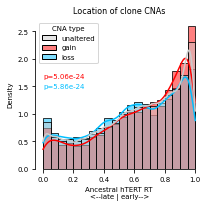

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

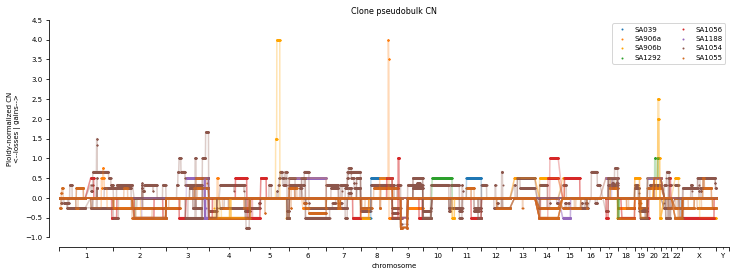

In [13]:
# plot the ancestral_rt_vs_clone_cna_histogram
fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))
ancestral_rt_vs_clone_cna_histogram(df_clone, ax)
plt.show()

# plot the clone cn profiles
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_clone_cn_profiles(cn_clone, ax, htert_clones)
plt.show()

### Plot the relationship between the clone CNA breakpoints and the ancestral RT

In [14]:
def get_bkpt_cmap():
    cmap = {
        'No': '#CCCCCC', # grey
        False: '#CCCCCC', # grey
        'Yes': 'C2', # green
        True: 'C2' # green
    }
    return cmap

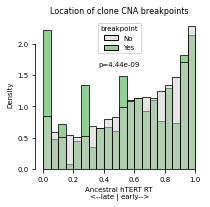

In [15]:
def ancestral_rt_vs_clone_bk_histogram(df, ax):
    # histogram of RT values split by breakpoint presence
    sns.histplot(
        data=df_clone, x='WT_pseudobulk_rt', hue='breakpoint', 
        common_norm=False, stat='density', ax=ax,
        palette=get_bkpt_cmap(), bins=20
    )
    ax.set_xlabel('Ancestral hTERT RT\n<--late | early-->')
    ax.set_title('Location of clone CNA breakpoints')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 3 because we are doing 3 pairwise comparisons (bonferonni correction)
    yes = df.query('`breakpoint`=="Yes"')['WT_pseudobulk_rt']
    no = df.query('`breakpoint`=="No"')['WT_pseudobulk_rt']
    pval = stats.ttest_ind(yes, no)[1]

    # add p-values to plot
    ax.text(0.5, 0.7, 'p={:.2e}'.format(pval), transform=ax.transAxes, ha='center', va='center')
   
    sns.despine(ax=ax, trim=True, offset=0)

fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))
ancestral_rt_vs_clone_bk_histogram(df_clone, ax)
plt.show()

### Plot the distribution of RT shifts in gains, losses and neutral CNAs


In [16]:
rt_diffs = pd.read_csv('../../analysis/sig_lines/subclonal_rt_diffs_summary.tsv', sep='\t')

# filter this dataframe to only consider CNAs that have >95% frequency within their given clone
rt_diffs = rt_diffs[rt_diffs['clone_freq'] > 0.98]

rt_diffs.head()

,chr,start,end,reference_rt,clone_rt,clone_rt_diff,clone_cna_type,reference_freq,clone_freq,dataset
1,11,66500001,67000000,0.990740,0.994,0.003260,gain,0.997333,0.994350,SA039
2,11,67000001,67500000,0.990190,0.992,0.001810,gain,0.997333,0.996234,SA039
3,11,67500001,68000000,0.967987,0.980,0.012013,gain,0.997333,0.996234,SA039
4,11,68000001,68500000,0.959226,0.972,0.012774,gain,0.997333,0.996234,SA039
5,11,68500001,69000000,0.886877,0.910,0.023123,gain,0.997706,0.998117,SA039


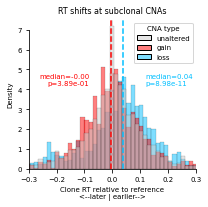

In [27]:
def plot_rt_shift_hist_per_bin(df, ax):
    # instead of a violin plot, show the histogram of clone_rt_diff with a hue of clone_cna_type
    df['CNA type'] = df['clone_cna_type']
    sns.histplot(
        data=df, x='clone_rt_diff', hue='CNA type', hue_order=['unaltered', 'gain', 'loss'], 
        palette=get_cna_cmap(), common_norm=False, stat='density', ax=ax,
        bins=120, rasterized=True
    )
    ax.set_xlim(-0.3, 0.3)
    ax.set_xticks(np.arange(-0.3, 0.4, 0.1))

    # compute the p-values between loss-unaltered and gain-unaltered
    # get the y-values for the loss-unaltered and gain-unaltered comparisons
    loss = df[df.clone_cna_type == 'loss'].clone_rt_diff
    unaltered = df[df.clone_cna_type == 'unaltered'].clone_rt_diff
    gain = df[df.clone_cna_type == 'gain'].clone_rt_diff
    # compute the p-value between loss-unaltered and gain-unaltered
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1]
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1]

    # annotate the median of each distribution with a dashed vertical line
    # annotate the line with the median value as text with 2 decimal places
    text_offset = 0.08
    text_height = 4.5
    loss_median = df[df.clone_cna_type=='loss'].clone_rt_diff.median()
    ax.axvline(x=loss_median, color=get_cna_cmap()['loss'], linestyle='--')
    ax.text(x=loss_median+text_offset, y=text_height, s='median={:.2f}\np={:.2e}'.format(loss_median, loss_unaltered_pval), color=get_cna_cmap()['loss'], ha='left', va='center')
    unaltered_median = df[df.clone_cna_type=='unaltered'].clone_rt_diff.median()
    ax.axvline(x=unaltered_median, color=get_cna_cmap()['unaltered'], linestyle='--')
    # ax.text(x=unaltered_median, y=10, s='median={:.2f}'.format(unaltered_median), color=get_cna_cmap()['unaltered'], ha='left', va='center')
    gain_median = df[df.clone_cna_type=='gain'].clone_rt_diff.median()
    ax.axvline(x=gain_median, color=get_cna_cmap()['gain'], linestyle='--')
    ax.text(x=gain_median-text_offset, y=text_height, s='median={:.2f}\np={:.2e}'.format(gain_median, gain_unaltered_pval), color=get_cna_cmap()['gain'], ha='right', va='center')

    ax.set_title('RT shifts at subclonal CNAs')

    ax.set_xlabel('Clone RT relative to reference\n<--later | earlier-->')

    sns.despine(ax=ax, trim=True, offset=0)


fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))
plot_rt_shift_hist_per_bin(rt_diffs, ax)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

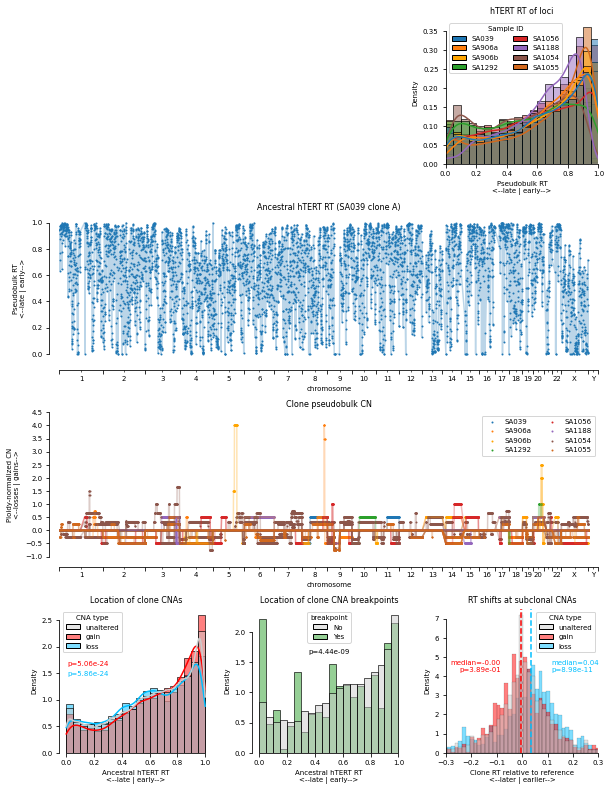

In [28]:
# create figure
fig, ax = plt.subplots(4, 3, figsize=(8.5, 11), tight_layout=True)

chrom_labels_to_remove = ['21']

# merge the 3 subplots in the 2nd row
ax[1, 0].remove()
ax[1, 1].remove()
ax[1, 2].remove()
ax[1, 0] = fig.add_subplot(4, 3, (4, 6))

# merge the 3 subplots in the 3rd row
ax[2, 0].remove()
ax[2, 1].remove()
ax[2, 2].remove()
ax[2, 0] = fig.add_subplot(4, 3, (7, 9))

# make the top left and top middle plots invisible
ax[0, 0].set_visible(False)
ax[0, 1].set_visible(False)

# plot the distribution of fraction of replicated bins for hTERT S-phase cells in the top right subplot
plot_loci_rt_distribution(htert_rt, ax[0, 2])

# plot the ancestral rt in the 2nd row and clone cn profiles in the 3rd row
plot_profiles(cn_clone, rt_clone, htert_clones, ax[2, 0], ax[1, 0], chrom_labels_to_remove=chrom_labels_to_remove)

# plot the histogram of ancestral RT values split by CNA type in the bottom left subplot
ancestral_rt_vs_clone_cna_histogram(df_clone, ax[3, 0])

# plot the histogram of ancestral RT values split by breakpoint presence in the bottom middle subplot
ancestral_rt_vs_clone_bk_histogram(df_clone, ax[3, 1])

# plot the histogram of clone RT shifts split by CNA type in the bottom right subplot
plot_rt_shift_hist_per_bin(rt_diffs, ax[3, 2])

fig.savefig('../../manuscript/main_figs/fig3.pdf', bbox_inches='tight', dpi=300)

plt.show()